# Simple RGCs simulation

In [1]:
import numpy as np, array
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
import matplotlib.image as mpimg
import matplotlib.cm as cm
import math
from mpl_toolkits.mplot3d import axes3d

import torch
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset

from numpy import save

In [25]:
%reload_ext autoreload

##### Simple RGCs simulation:

In [6]:
_default_2Dgaussian_p = (1,1,1,0,0,0,0)
def gaussian_2D(xz, sigma_x, sigma_z, amp, theta, x0, z0, y0):
    """Two dimensional Gaussian function
    params:
        - xz: meshgrid of x and z coordinates at which to evaluate the points
        - sigma_x: width of the gaussian
        - sigma_z: height of the gaussian
        - amp: amplitude of the gaussian
        - theta: angle of the gaussian (in radian)
        - x0: shift in x of the gaussian
        - z0: shift in z of the gaussian
        - y0: shift in y of the gaussian
    """
    (x,z) = xz
    x0, z0 = float(x0), float(z0)
    a =  (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_z**2)
    b = -(np.sin(2*theta)) /(4*sigma_x**2) + (np.sin(2*theta)) /(4*sigma_z**2)
    c =  (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_z**2)
    g = amp * np.exp( -(a*((x-x0)**2) + 2*b*(x-x0)*(z-z0) + c*((z-z0)**2))) + y0
    return g.ravel()

def mexicanHat(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0):
    """Sum of two 2D Gaussian function. For the params, see `gaussian_2D`.
     However, both share the y0 parameter."""
    return (gaussian_2D(xz, sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, 0) 
            + gaussian_2D(xz, sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, 0) + y0)

def ELU(r):
    if r>0:
        return r+1
    else:
        return np.exp(r) + 1    
    
def RF_circular_CS(vis_field_width, vis_field_height, x_rf_center, z_rf_center, polarity, plot=False):
    x,y = np.meshgrid(np.linspace(0,vis_field_width,vis_field_width),np.linspace(0,vis_field_height,vis_field_height))
    
    if polarity==1:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 2, 2, 1, 0, x_rf_center, z_rf_center
        sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 3, 3, -0.5, 0, x_rf_center, z_rf_center, 0
    else:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 2, 2, -1, 0, x_rf_center, z_rf_center
        sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 3, 3, 0.5, 0, x_rf_center, z_rf_center, 0
        
    z = mexicanHat((x,y), sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0).reshape(vis_field_height,vis_field_width)
    if plot==True:
        fig = plt.figure(figsize=(5,4))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z, rstride=3, cstride=3, label=f"x_rf_center={x_rf_center}  z_rf_center={z_rf_center} \n amp_center={amp_1}  amp_surround={amp_2}")
        _ = ax.legend()
    return z

def RF_oval_CS(vis_field_width, vis_field_height, rf_theta ,x_rf_center, z_rf_center, polarity, plot=False):
    x,y = np.meshgrid(np.linspace(0,vis_field_width,vis_field_width),np.linspace(0,vis_field_height,vis_field_height))
    
    if polarity==1:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 2, 3, 1, rf_theta, x_rf_center, z_rf_center
        sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 3, 4, -0.5, rf_theta, x_rf_center, z_rf_center, 0
    else:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 2, 3, -1, rf_theta, x_rf_center, z_rf_center
        sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 3, 4, 0.5, rf_theta, x_rf_center, z_rf_center, 0
        
    z = mexicanHat((x,y), sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1,
                           sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0).reshape(vis_field_height,vis_field_width)
    if plot==True:
        fig = plt.figure(figsize=(5,4))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z, rstride=3, cstride=3, label=f"x_rf_center={x_rf_center}  z_rf_center={z_rf_center} \n amp_center={amp_1}  amp_surround={amp_2} \n rf_theta={rf_theta}")
        _ = ax.legend()
    return z

def RF_circular(vis_field_width, vis_field_height, x_rf_center, z_rf_center, polarity, plot=False):
    x,y = np.meshgrid(np.linspace(0,vis_field_width,vis_field_width),np.linspace(0,vis_field_height,vis_field_height))
    
    if polarity==1:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, y0 = 1, 1, 1, 0, x_rf_center, z_rf_center, 0
    else:
        sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, y0 = 1, 1, -1, 0, x_rf_center, z_rf_center, 0
        
    z = (gaussian_2D((x,y), sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, y0)).reshape(vis_field_height,vis_field_width)
    
    if plot==True:
        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(x, y, z, rstride=3, cstride=3, label=f"x_rf_center={x_rf_center}  z_rf_center={z_rf_center} \n amp_center={amp_1}")
        _ = ax.legend()
    return z

def RF_ON_OFF(vis_field_width, vis_field_height, x_rf_center, z_rf_center, plot=False):
    x,y = np.meshgrid(np.linspace(0,vis_field_width,vis_field_width),np.linspace(0,vis_field_height,vis_field_height))
    
    sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1 = 3, 3, 0.5, 0, x_rf_center, z_rf_center
    sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0 = 3, 3, -0.5, 0, x_rf_center, z_rf_center, 0
       
    z_ON = (gaussian_2D((x,y), sigma_x_1, sigma_z_1, amp_1, theta_1, x0_1, z0_1, y0)).reshape(vis_field_height,vis_field_width)
    z_OFF = (gaussian_2D((x,y), sigma_x_2, sigma_z_2, amp_2, theta_2, x0_2, z0_2, y0)).reshape(vis_field_height,vis_field_width)
    
    if plot==True:
        fig = plt.figure(figsize=(6,5))
        ax = fig.add_subplot(121, projection='3d')
        ax.plot_wireframe(x, y, z_ON, rstride=3, cstride=3, label=f"x_rf_center={x_rf_center}  z_rf_center={z_rf_center} \n amp_center_ON={amp_1}")
        _ = ax.legend()
        ax1 = fig.add_subplot(122, projection='3d')
        ax1.plot_wireframe(x, y, z_OFF, rstride=3, cstride=3, label=f"x_rf_center={x_rf_center}  z_rf_center={z_rf_center} \n amp_center_OFF={amp_2}")
        _ = ax1.legend()
        plt.tight_layout()
        
    return z_ON, z_OFF

def RGC_response(rf, image, plot=False, seed=None):
    Img_barHat = image * rf
    
    if plot==True:
        fig, ax = plt.subplots(3, figsize=(8,8))
        ax[0].imshow(image)
        ax[0].set_title("Image")
        ax[1].imshow(rf)
        ax[1].set_title("RGC RF")
        ax[2].imshow(Img_barHat)
        ax[2].set_title("RGC Response")
        plt.tight_layout()
        
    if seed is not None:
        np.random.seed(seed)
        
    g = ELU(sum(Img_barHat.ravel()))
    spikes = np.random.poisson(lam=g, size=None)
    return spikes

def RGC_response_ON_OFF(rf_ON, rf_OFF, image, plot=False, seed=None):
    Img_barHat_ON = image * rf_ON
    Img_barHat_OFF = image * rf_OFF
    
    if plot==True:
        fig, ax = plt.subplots(4, figsize=(10,10))
        ax[0].imshow(image)
        ax[0].set_title("Image")
        ax[1].imshow(rf_ON)
        ax[1].set_title("RGC ON RF")
        ax[2].imshow(rf_OFF)
        ax[2].set_title("RGC OFF RF")
        ax[3].imshow(Img_barHat_ON+Img_barHat_OFF)
        ax[3].set_title("RGC Response")
        plt.tight_layout()
        
    if seed is not None:
        np.random.seed(seed)
        
    g = ELU(sum(Img_barHat_ON.ravel())) + ELU(sum(Img_barHat_OFF.ravel())) 
    spikes = np.random.poisson(lam=g, size=None)
    return spikes

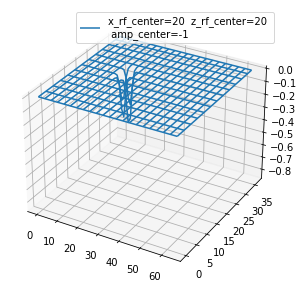

In [7]:
#Generate circular ON receptive field of one RGC
rf = RF_circular(vis_field_width = 64, vis_field_height = 36, x_rf_center = 20, z_rf_center = 20, polarity =-1, plot=True)

In [3]:
#Generate circular ON center OFF surround receptive field of one RGC
rf_CS = RF_circular_CS(vis_field_width = 64, vis_field_height = 36, x_rf_center = 20, z_rf_center = 20, polarity =-1, plot=True)

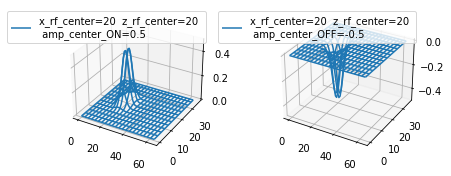

In [16]:
#Generate ON-OFF receptive field of RGC
rf_ON,rf_OFF = RF_ON_OFF(vis_field_width = 64, vis_field_height = 36, rf_theta = 0, x_rf_center = 20, z_rf_center=20, plot = True)

In [4]:
x = np.load('D://inception_loop/RGC_sim_data/data/static27012021_original_images/data/images/'+str(0)+'.npy')[0]

In [37]:
ELU(sum(bar.ravel()))

1.0

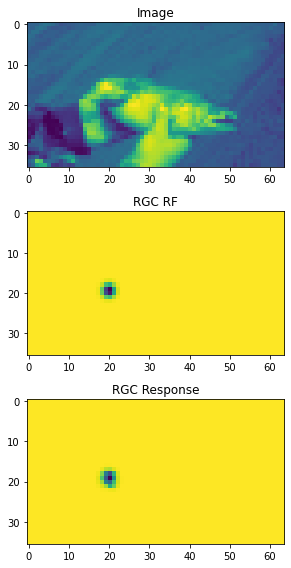

In [8]:
bar=RGC_response(rf, image=(x), plot=True)

762

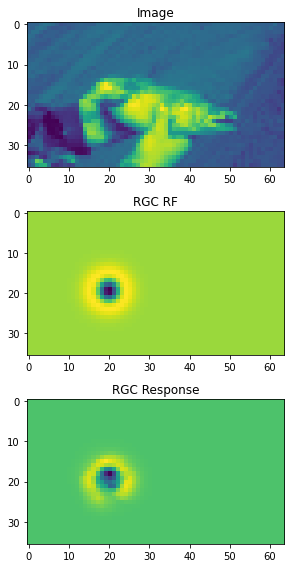

In [16]:
RGC_response(rf_CS, image=x, plot=True)

In [31]:
#rf = np.load('D://inception_loop/RGC_sim_data/data/static27012021_original_images/RFs/990.npy')
#x = images[2]
#Generate the response of one RGC
RGC_response_ON_OFF(rf_ON, rf_OFF, image=x, plot=True)
#plt.savefig("D://inception_loop/RGC_sim_data/results/Image_RF_response.png")

3518

##### RGCs response generation to natural images dataset:

In [6]:
#Retrieve image sets from evaluation data set of lurz2020 #5993 images randomly selected as train, validation or test
images_paths = 'D://inception_loop/RGC_sim_data/data/static27012021_original_images'
paths = 'D://inception_loop/RGC_sim_data/data/static27012021_small_RF'

images = []
for n in range(5993):
    x = np.load(images_paths+'/data/images/'+str(n)+'.npy')
    images.append(x-np.mean(x))
    
images = np.vstack(images)

In [8]:
#Generate receptive fields of several RGCs #2304 RGCs - haf ON/half OFFù
import random
rf_ON = []
rf_ON_center_coord = []
rf_OFF = []
rf_OFF_center_coord = []
i = 0
image = images[0]
for width_center in range(image.shape[1]):
    for height_center in range(image.shape[0]):
        if (i % 2) == 0:
            #theta = random.uniform(0, 6.2)
            rf = RF_circular(image.shape[1], image.shape[0], width_center, height_center, 1, plot=False) 
            rf_ON.append(rf)
            rf_ON_center_coord = np.array([width_center, height_center])
            save('D://inception_loop/RGC_sim_data/data/static27012021_small_RF/RFs/'+str(i)+'.npy', rf)
            save('D://inception_loop/RGC_sim_data/data/static27012021_small_RF/RFs/center_coord_'+str(i)+'.npy',rf_ON_center_coord)
        else:
            #theta = random.uniform(0, 6.2)
            rf = RF_circular(image.shape[1], image.shape[0], width_center, height_center, -1, plot=False) 
            rf_OFF.append(rf)
            rf_OFF_center_coord = np.array([width_center, height_center])
            save('D://inception_loop/RGC_sim_data/data/static27012021_small_RF/RFs/'+str(i)+'.npy', rf)
            save('D://inception_loop/RGC_sim_data/data/static27012021_small_RF/RFs/center_coord_'+str(i)+'.npy',rf_OFF_center_coord)
        i+=1

In [9]:
#Generate responses of simulated RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

i=0
for image in images:
    responses = []
    for rfon, rfoff in zip(rf_ON, rf_OFF):
        rgc_on_response = RGC_response(rf=rfon, image=image, plot=False)
        responses.append(rgc_on_response)
        rgc_off_response = RGC_response(rf=rfoff, image=image, plot=False)
        responses.append(rgc_off_response)
    # save numpy array as npy file
    save('D://inception_loop/RGC_sim_data/data/static27012021_small_RF/data/responses/'+str(i)+'.npy', responses)
    if (i % 1000) == 0:
        print(i)
    i+=1
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
--- 4930.797226428986 seconds ---


In [17]:
#Generate data - pupil_center npy files
#Array with list of two values- coordinates of pupil center - [759.87785056, 472.71767702]

for j in range(len(images)):
    pupil_center = np.array([0.0,0.0])
    # save numpy array as npy file
    save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/data/pupil_center/'+str(j)+'.npy', pupil_center)

FileNotFoundError: [Errno 2] No such file or directory: './Lurz_2020_code/notebooks/data/RGC_sim/static27012021/data/pupil_center/0.npy'

In [ ]:
#Generate data - behavior npy files -> use include_behavior= False in static_loaders
#Array with list of three values - pupil dilation, temporal derivative and absolute running speed - [99.2678426 ,  6.66429682,  0. ] 

In [18]:
#Generate metadata - neurons - unit_ids npy array
unit_ids = np.array(range(1, len(responses)+1))
#Generate metadata - neurons - animal_ids npy array
animal_ids = np.repeat(1, len(responses))
#Generate metadata - neurons - area npy array
area = ['retina']*len(responses)
#Generate metadata - neurons - layer npy array
layer = ['RGC']*len(responses)
#Generate metadata - neurons - scan_idx npy array
scan_idx = np.repeat(14, len(responses))
#Generate metadata - neurons - sessions npy array
sessions = np.repeat(6, len(responses))

# save numpy arrays as npy arrays
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/neurons/unit_ids.npy', unit_ids)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/neurons/animal_ids.npy', animal_ids)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/neurons/area.npy', area)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/neurons/layer.npy', layer)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/neurons/scan_idx.npy', scan_idx)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/neurons/sessions.npy', sessions)

In [267]:
#Generate metadata - trials - animal_id npy array
animal_id = np.repeat(1, len(responses))
#Generate metadata - trials - scan_idx npy array
scan_idx = np.repeat(14, len(responses))
#Generate metadata - trials - session npy array
session = np.repeat(6, len(responses))

# save numpy arrays as npy arrays
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/trials/animal_id.npy', animal_id)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/trials/scan_idx.npy', scan_idx)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/trials/session.npy', session)

In [269]:
#Generate metadata - statistics - pupil_center - all
pupil_center_max_all = np.array([0.0,0.0])
pupil_center_mean_all = np.array([0.0,0.0])
pupil_center_median_all = np.array([0.0,0.0])
pupil_center_min_all = np.array([0.0,0.0])
pupil_center_std_all = np.array([0.0,0.0])
#Generate metadata - statistics - pupil_center - stimulus_frame
pupil_center_max_sf = np.array([0.0,0.0])
pupil_center_mean_sf = np.array([0.0,0.0])
pupil_center_median_sf = np.array([0.0,0.0])
pupil_center_min_sf = np.array([0.0,0.0])
pupil_center_std_sf = np.array([0.0,0.0])

# save numpy arrays as npy arrays - all
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/max.npy', pupil_center_max_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/mean.npy', pupil_center_mean_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/median.npy', pupil_center_median_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/min.npy', pupil_center_min_all)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/all/std.npy', pupil_center_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/max.npy', pupil_center_max_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/mean.npy', pupil_center_mean_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/median.npy', pupil_center_median_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/min.npy', pupil_center_min_sf)
save('./Lurz_2020_code/notebooks/data/RGC_sim/static27012021/meta/statistics/pupil_center/stimulus_frame/std.npy', pupil_center_std_sf)

In [10]:
#Generate responses of simulated RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

responses_all = []
for k in range(len(images)):
    responses_all.append(np.load('D://inception_loop/RGC_sim_data/data/static27012021_small_RF/data/responses/'+str(k)+'.npy'))
    if (k % 1000) == 0:
        print(k)
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
--- 7.55249285697937 seconds ---


In [20]:
#Generate metadata - statistics - responses - all
responses_max_all = np.max(responses_all, axis=0)
responses_mean_all = np.mean(responses_all, axis=0)
responses_median_all = np.median(responses_all, axis=0)
responses_min_all = np.min(responses_all, axis=0)
responses_std_all = np.std(responses_all, axis=0)
#Generate metadata - statistics - responses - stimulus_frame

# save numpy arrays as npy arrays - all
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/all/max.npy', responses_max_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/all/mean.npy', responses_mean_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/all/median.npy', responses_median_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/all/min.npy', responses_min_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/all/std.npy', responses_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/stimulus_frame/max.npy', responses_max_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/stimulus_frame/mean.npy', responses_mean_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/stimulus_frame/median.npy', responses_median_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/stimulus_frame/min.npy', responses_min_all)
save('D://inception_loop/RGC_sim_data/data/static27012021/meta/statistics/responses/stimulus_frame/std.npy', responses_std_all)

In [13]:
#Padding image sets from evaluation data set of lurz2020 #5993 images randomly selected as train, validation or test
images_paths = 'D://inception_loop/RGC_sim_data/data/static27012021_original_images'
paths = 'D://inception_loop/RGC_sim_data/data/static27012021_small_RF'

images = []
for n in range(5993):
    x = np.load(images_paths+'/data/images/'+str(n)+'.npy')
    #x_padded = np.pad(x[0], pad_width=20, mode='constant', 
    #          constant_values=0)
    np.save(paths+'/data/images/'+str(n)+'.npy', x)

In [15]:
paths = 'D://inception_loop/RGC_sim_data/data/static27012021_small_RF'
plt.imshow(np.load(paths+'/data/images/'+str(100)+'.npy')[0])

----------------------------------------------------------------

##### RGCs with different RFs response generation to natural images dataset:
Response of OFF RGC CORRECTED!!!  

-ON CIRC RF  
-OFF CIRC RF  
-ON-OFF RF  
-ON CENTER OVAL RF  
-OFF CENTER OVAL RF

In [6]:
#Retrieve image sets from evaluation data set of lurz2020 #5993 images randomly selected as train, validation or test
images_paths = 'D://inception_loop/RGC_sim_data/data/static27012021_original_images'
paths = 'D://inception_loop/RGC_sim_data/data/static27012021_diff_RFs'

images = []
for n in range(5993):
    x = np.load(images_paths+'/data/images/'+str(n)+'.npy')
    #Subtract mean from images for computation of RGCs response
    images.append(x-np.mean(x))

images = np.vstack(images)

In [4]:
#Generate overlapping receptive fields of several types of RGCs # RGCs

import random
rfs_ON = []
rfs_OFF = []
rfs_ON_OFF1 = []
rfs_ON_OFF2 = []
rfs_ON_OVAL = []
rfs_OFF_OVAL = []
i = 0
image = images[0]
for width_center in np.linspace(0, image.shape[1], 44, dtype=int):
    for height_center in np.linspace(0, image.shape[0], 16, dtype=int):
        theta = random.uniform(0, 6.2)
        rf_ON = RF_circular(image.shape[1], image.shape[0], width_center, height_center, 1, plot=False) 
        np.save(paths+'/RFs/'+str(i)+'.npy', rf_ON)
        rfs_ON.append(rf_ON)
        i+=1
        rf_OFF = RF_circular(image.shape[1], image.shape[0], width_center, height_center, -1, plot=False)
        np.save(paths+'/RFs/'+str(i)+'.npy', rf_OFF)
        rfs_OFF.append(rf_OFF)
        i+=1
        rf_ON_OFF1, rf_ON_OFF2 = RF_ON_OFF(image.shape[1], image.shape[0], width_center, height_center, plot=False)
        np.save(paths+'/RFs/'+str(i)+'_1.npy', rf_ON_OFF1)
        np.save(paths+'/RFs/'+str(i)+'_2.npy', rf_ON_OFF2)
        rfs_ON_OFF1.append(rf_ON_OFF1)
        rfs_ON_OFF2.append(rf_ON_OFF2)
        i+=1
        rf_ON_oval = RF_oval_CS(image.shape[1], image.shape[0], theta, width_center, height_center, 1, plot=False) 
        np.save(paths+'/RFs/'+str(i)+'.npy', rf_ON_oval)
        rfs_ON_OVAL.append(rf_ON_oval)
        i+=1
        rf_OFF_oval = RF_oval_CS(image.shape[1], image.shape[0], theta, width_center, height_center, -1, plot=False) 
        np.save(paths+'/RFs/'+str(i)+'.npy', rf_OFF_oval)
        rfs_OFF_OVAL.append(rf_OFF_oval)
        i+=1

In [8]:
#Generate responses of simulated types of RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

i=0
for image in images:
    responses = []
    for rfon, rfoff, rfon_off1, rfon_off2, rfon_oval, rfoff_oval in zip(rfs_ON, rfs_OFF, rfs_ON_OFF1, rfs_ON_OFF2, rfs_ON_OVAL, rfs_OFF_OVAL):
        rgc_on_response = RGC_response(rf=rfon, image=image, plot=False)
        responses.append(rgc_on_response)
        rgc_off_response = RGC_response(rf=rfoff, image=image, plot=False)
        responses.append(rgc_off_response)
        rgc_on_off_response = RGC_response_ON_OFF(rf_ON=rfon_off1, rf_OFF=rfon_off2, image=image, plot=False)
        responses.append(rgc_on_off_response)
        rgc_on_oval_response = RGC_response(rf=rfon_oval, image=image, plot=False)
        responses.append(rgc_on_oval_response)
        rgc_off_oval_response = RGC_response(rf=rfoff_oval, image=image, plot=False)
        responses.append(rgc_off_oval_response)
        
    # save numpy array as npy file
    save(paths+'/data/responses/'+str(i)+'.npy', responses)
    if (i % 1000) == 0:
        print(i)
    i+=1
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
--- 9170.4353454113 seconds ---


In [9]:
#Generate metadata - neurons - unit_ids npy array
unit_ids = np.array(range(1, len(responses)+1))
#Generate metadata - neurons - animal_ids npy array
animal_ids = np.repeat(1, len(responses))
#Generate metadata - neurons - area npy array
area = ['retina']*len(responses)
#Generate metadata - neurons - layer npy array
layer = ['RGC']*len(responses)
#Generate metadata - neurons - scan_idx npy array
scan_idx = np.repeat(14, len(responses))
#Generate metadata - neurons - sessions npy array
sessions = np.repeat(6, len(responses))

# save numpy arrays as npy arrays
save(paths+'/meta/neurons/unit_ids.npy', unit_ids)
save(paths+'/meta/neurons/animal_ids.npy', animal_ids)
save(paths+'/meta/neurons/area.npy', area)
save(paths+'/meta/neurons/layer.npy', layer)
save(paths+'/meta/neurons/scan_idx.npy', scan_idx)
save(paths+'/meta/neurons/sessions.npy', sessions)

In [10]:
#Generate responses of simulated RGCs to the image set from evaluation data set of lurz2020
import time
start_time = time.time()

responses_all = []
for k in range(len(images)):
    responses_all.append(np.load(paths+'/data/responses/'+str(k)+'.npy', allow_pickle=True))
    if (k % 1000) == 0:
        print(k)
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1000
2000
3000
4000
5000
--- 7.885213851928711 seconds ---


In [11]:
responses_all

(3520,)

In [12]:
#Generate metadata - statistics - responses - all
responses_max_all = np.max(responses_all, axis=0)
responses_mean_all = np.mean(responses_all, axis=0)
responses_median_all = np.median(responses_all, axis=0)
responses_min_all = np.min(responses_all, axis=0)
responses_std_all = np.std(responses_all, axis=0)
#Generate metadata - statistics - responses - stimulus_frame

# save numpy arrays as npy arrays - all
save(paths+'/meta/statistics/responses/all/max.npy', responses_max_all)
save(paths+'/meta/statistics/responses/all/mean.npy', responses_mean_all)
save(paths+'/meta/statistics/responses/all/median.npy', responses_median_all)
save(paths+'/meta/statistics/responses/all/min.npy', responses_min_all)
save(paths+'/meta/statistics/responses/all/std.npy', responses_std_all)

# save numpy arrays as npy arrays - stimulus_frame
save(paths+'/meta/statistics/responses/stimulus_frame/max.npy', responses_max_all)
save(paths+'/meta/statistics/responses/stimulus_frame/mean.npy', responses_mean_all)
save(paths+'/meta/statistics/responses/stimulus_frame/median.npy', responses_median_all)
save(paths+'/meta/statistics/responses/stimulus_frame/min.npy', responses_min_all)
save(paths+'/meta/statistics/responses/stimulus_frame/std.npy', responses_std_all)

In [13]:
#Padding image sets from evaluation data set of lurz2020 #5993 images randomly selected as train, validation or test
images_paths = 'D://inception_loop/RGC_sim_data/data/static27012021_original_images'
paths = 'D://inception_loop/RGC_sim_data/data/static27012021_diff_RFs'

images = []
for n in range(5993):
    x = np.load(images_paths+'/data/images/'+str(n)+'.npy')
    x_padded = np.pad(x[0], pad_width=20, mode='constant', 
              constant_values=0)
    np.save(paths+'/data/images/'+str(n)+'.npy', [x_padded])